In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.model_selection
import albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2
import itertools
import os
import time
from pathlib import Path
from tqdm.notebook import tqdm
import math
import pickle
from scipy import ndimage

# pytorch stuff
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

# need for AMP
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

torch.manual_seed(3)
from tqdm.notebook import tqdm

## What is Semantic Segmentation?

Semantic Segmentation is an image analysis task in which we classify each pixel in the image into a class. <br/>

There are a few more types of Segmentation, you can read about it more here: https://www.learnopencv.com/image-segmentation/
Today we will focus on Semantic Segmentation

So, let's say we have the following image.

![](https://lh3.googleusercontent.com/-ELUnFgFJqUU/XPPXOOmhfMI/AAAAAAAAAP0/2cabsTI9uGUYxM3O3w4EOxjR_iJvEQAvACK8BGAs/s374/index3.png)
<small> Source: Pexels </small>

And then given the above image its semantically segmentated image would be the following

![](https://lh3.googleusercontent.com/-gdUavPeOxdg/XPPXQngAnvI/AAAAAAAAAQA/yoksBterCGQGt-lv3aX4kfyMUDXTar7yACK8BGAs/s374/index4.png)

As you can see, that each pixel in the image is classified to its respective class.

## Using torchvision for Semantic Segmentation

Now before we get started, we need to know about the inputs and outputs of these semantic segmentation models.<br/>
So, let's start!

These models expect a 3-channled image which is normalized with the Imagenet mean and standard deviation, i.e., <br/>
`mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`

So, the input is `[Ni x Ci x Hi x Wi]`<br/>
where,
- `Ni` -> the batch size
- `Ci` -> the number of channels (which is 3)
- `Hi` -> the height of the image
- `Wi` -> the width of the image

And the output of the model is `[No x Co x Ho x Wo]`<br/>
where,
- `No` -> is the batch size (same as `Ni`)
- `Co` -> **is the number of classes that the dataset have!**
- `Ho` -> the height of the image (which is the same as `Hi` in almost all cases)
- `Wo` -> the width of the image (which is the same as `Wi` in almost all cases)


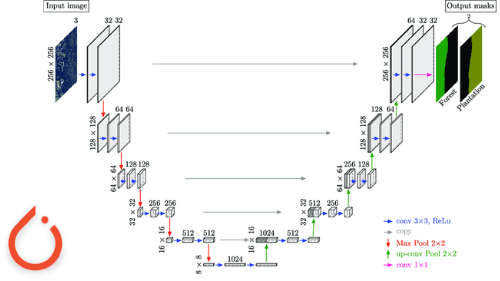

In [2]:
# add shortcut to drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
PATH = Path("/content/drive/MyDrive/imgs_266_532/")

In [4]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [5]:
list((PATH/"train").iterdir())[:10] 

[PosixPath('/content/drive/MyDrive/imgs_266_532/train/krefeld_000000_035124_leftImg8bit.png'),
 PosixPath('/content/drive/MyDrive/imgs_266_532/train/krefeld_000000_015494_leftImg8bit.png'),
 PosixPath('/content/drive/MyDrive/imgs_266_532/train/krefeld_000000_020033_leftImg8bit.png'),
 PosixPath('/content/drive/MyDrive/imgs_266_532/train/krefeld_000000_000316_leftImg8bit.png'),
 PosixPath('/content/drive/MyDrive/imgs_266_532/train/krefeld_000000_006274_leftImg8bit.png'),
 PosixPath('/content/drive/MyDrive/imgs_266_532/train/krefeld_000000_025434_leftImg8bit.png'),
 PosixPath('/content/drive/MyDrive/imgs_266_532/train/krefeld_000000_013257_leftImg8bit.png'),
 PosixPath('/content/drive/MyDrive/imgs_266_532/train/krefeld_000000_030400_leftImg8bit.png'),
 PosixPath('/content/drive/MyDrive/imgs_266_532/train/krefeld_000000_034686_leftImg8bit.png'),
 PosixPath('/content/drive/MyDrive/imgs_266_532/train/krefeld_000000_024604_leftImg8bit.png')]

(<matplotlib.image.AxesImage at 0x7fea3fa18450>, (266, 532, 3))

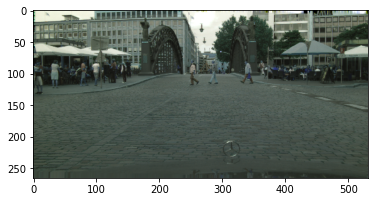

In [6]:
path = PATH/"train/hamburg_000000_105123_leftImg8bit.png"
im1 = read_image(path)
plt.imshow(im1), im1.shape

In [7]:
list((PATH/"labels").iterdir())[:10] 

[PosixPath('/content/drive/MyDrive/imgs_266_532/labels/stuttgart_000034_000019_gtFine_labelTrainIds.png'),
 PosixPath('/content/drive/MyDrive/imgs_266_532/labels/stuttgart_000049_000019_gtFine_labelTrainIds.png'),
 PosixPath('/content/drive/MyDrive/imgs_266_532/labels/stuttgart_000096_000019_gtFine_labelTrainIds.png'),
 PosixPath('/content/drive/MyDrive/imgs_266_532/labels/stuttgart_000071_000019_gtFine_labelTrainIds.png'),
 PosixPath('/content/drive/MyDrive/imgs_266_532/labels/stuttgart_000010_000019_gtFine_labelTrainIds.png'),
 PosixPath('/content/drive/MyDrive/imgs_266_532/labels/stuttgart_000123_000019_gtFine_labelTrainIds.png'),
 PosixPath('/content/drive/MyDrive/imgs_266_532/labels/stuttgart_000125_000019_gtFine_labelTrainIds.png'),
 PosixPath('/content/drive/MyDrive/imgs_266_532/labels/stuttgart_000027_000019_gtFine_labelTrainIds.png'),
 PosixPath('/content/drive/MyDrive/imgs_266_532/labels/erfurt_000058_000019_gtFine_labelTrainIds.png'),
 PosixPath('/content/drive/MyDrive/imgs_

(<matplotlib.image.AxesImage at 0x7fea3d4bb610>, (266, 532, 3))

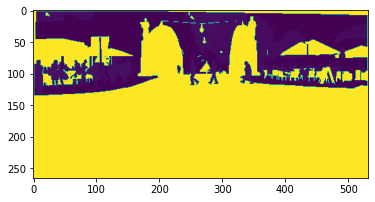

In [8]:
path = PATH/"labels/hamburg_000000_105123_gtFine_labelTrainIds.png"
label_img = read_image(path)
plt.imshow(label_img[:,:,0]), label_img.shape

In [9]:
(label_img[:,:,0] == label_img[:,:,2]).sum(), 266*532

(141512, 141512)

In [10]:
# 20 classes
label_img.reshape(-1).min(), label_img.reshape(-1).max()

(1, 255)

In [11]:
classes = torch.unique(torch.tensor(label_img))
len(classes)

12

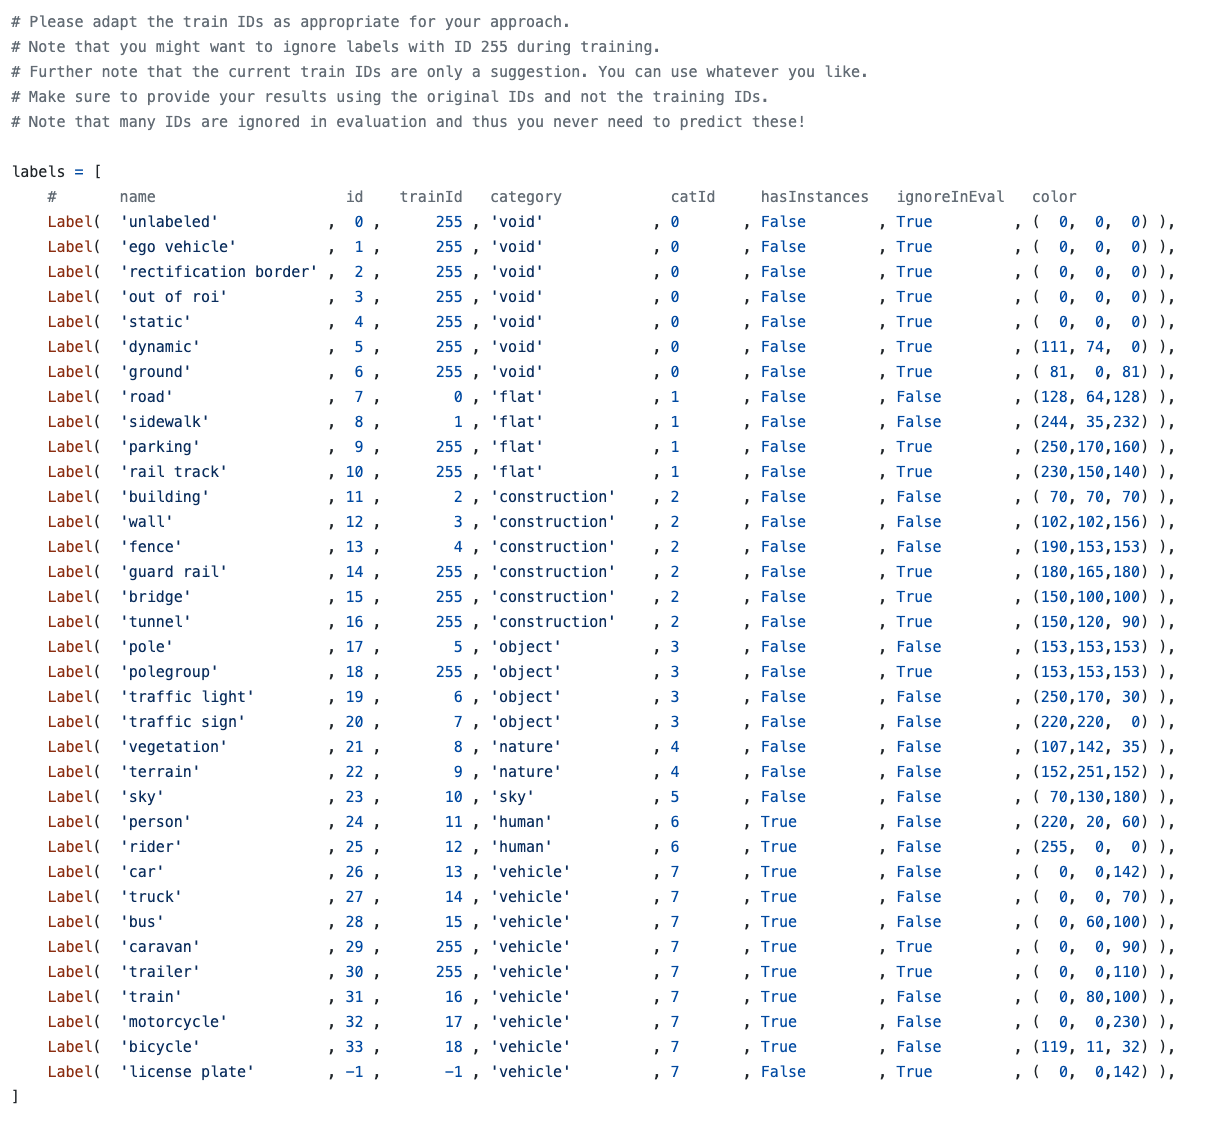

## albumentations for data augmentation

In [12]:
crop = (512, 256)
transformImg = A.Compose([A.RandomCrop(width=crop[0],height=crop[1]),
                          A.HorizontalFlip(p=.5),
                          A.VerticalFlip(p=.5),
                          A.Rotate(limit = 10, border_mode = cv2.BORDER_REFLECT, value = 0.0, p = .75),
                          A.GridDistortion(border_mode=cv2.BORDER_REFLECT, value=0.0, p=0.75)]) 

In [13]:
centercrop = A.CenterCrop(width=crop[0],height=crop[1])


In [14]:
path = PATH/"train/zurich_000051_000019_leftImg8bit.png"
x = read_image(path)
path = PATH/"labels/zurich_000051_000019_gtFine_labelTrainIds.png"
y = read_image(path)

In [15]:
def plot_two_imgs(im1, im2):
    f = plt.figure(figsize=(12,8))
    f.add_subplot(1,2, 1)
    plt.imshow(im1)
    f.add_subplot(1,2, 2)
    plt.imshow(im2)

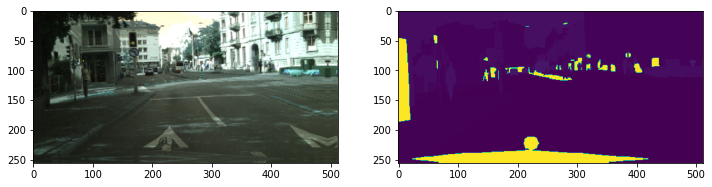

In [16]:
transformed = transformImg(image=x, mask=y[:,:,0]) 
img = transformed['image']
mask = transformed['mask']
plot_two_imgs(img, mask)

(<matplotlib.image.AxesImage at 0x7fea3d3ff650>, (256, 512, 3))

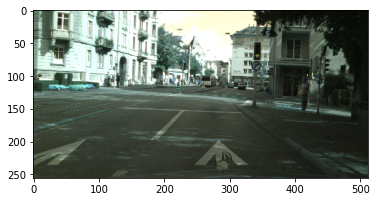

In [17]:
transformed = centercrop(image=x, mask=y) 
img = transformed['image']
mask = transformed['mask']
plt.imshow(img), img.shape


# Mapping categories

In [18]:
# Mapping of ignore categories and valid ones (numbered from 1-19)
mapping_20 = { 
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
        6: 0,
        7: 1,
        8: 2,
        9: 0,
        10: 0,
        11: 3,
        12: 4,
        13: 5,
        14: 0,
        15: 0,
        16: 0,
        17: 6,
        18: 0,
        19: 7,
        20: 8,
        21: 9,
        22: 10,
        23: 11,
        24: 12,
        25: 13,
        26: 14,
        27: 15,
        28: 16,
        29: 0,
        30: 0,
        31: 17,
        32: 18,
        33: 19,
        -1: 0
        }
 
def encode_labels(mask):
    label_mask = np.zeros_like(mask)
    for k in mapping_20:
        label_mask[mask == k] = mapping_20[k]
    return label_mask       
        
        

# Dataset


In [19]:
class CityScapesDataset(Dataset):
    def __init__(self, data_path, folder, transform=True, crop = (512, 256)):
        """data_path = PATH/"imgs_266_532"
           folder is in [val, train, test]
           trasform should be True for train
        """                       
        self.imgs_files = [f for f in (data_path/folder).glob('*.png')]
        self.label_names = [(f.name).split("_leftImg8bit.png")[0] + 
                          "_gtFine_labelTrainIds.png" for f in self.imgs_files]

        self.labels_files = [data_path/"labels"/f for f in self.label_names] 
        self.transform = transform


        self.train_transforms = A.Compose([
            A.HorizontalFlip(p=.5),
            A.VerticalFlip(p=.5),
            A.Rotate(limit = 10, border_mode = cv2.BORDER_REFLECT, value = 0.0, p = .75),
            A.GridDistortion(border_mode=cv2.BORDER_REFLECT, value=0.0, p=0.75),
            A.RandomCrop(width=crop[0],height=crop[1]),
            ToTensorV2()
            ]) 
        
        self.val_transforms = A.Compose([
            A.CenterCrop(width=crop[0],height=crop[1]),
            ToTensorV2()
            ])

    def __len__(self):
         return len(self.imgs_files)

        
    def __getitem__(self, index):
        im_path = self.imgs_files[index]
        label_path = self.labels_files[index]
        im = read_image(im_path)
        label = read_image(label_path)
        label_map = encode_labels(label)
        
        if self.transform:
            transformed = self.train_transforms(image=im, mask=label_map[:,:,0])
        else:
            transformed = self.val_transforms(image=im, mask=label_map[:,:,0])
        
        x = transformed['image']/255.
        y = transformed['mask'].type(torch.LongTensor)
        return x, y
            
        
    
        
        

In [20]:
ds_train = CityScapesDataset(PATH, "train")
ds_val = CityScapesDataset(PATH, "val",  transform=False)

In [21]:
x, y = ds_train[0]
x.shape, y.shape

(torch.Size([3, 256, 512]), torch.Size([256, 512]))

In [22]:
len(ds_train), len(ds_val)

(2975, 500)

# DataLoader

In [23]:
dl_train = DataLoader(ds_train, batch_size=16, shuffle=True, num_workers=2)
dl_val = DataLoader(ds_val, batch_size=16, shuffle=False, num_workers=2)

# Device

In [24]:
# Select type of processor to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cuda'):
    print("-Type of precessor to be used: 'gpu'")
else:
    print("-Type of precessor to be used: 'cpu'")

-Type of precessor to be used: 'gpu'


# Basic UNet model

In [30]:
# basic unet with batch normalization
f_size = 7
padding = (int((f_size-1)/2),int((f_size-1)/2))
chs = [32, 64, 128, 256, 512] #, 1024]

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, f_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, f_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

    
class unet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        # pooling
        self.pool = nn.MaxPool2d(2,2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # ENCODER
        self.conv00 = ConvBlock(3, 32)
        self.conv10 = ConvBlock(32, 64)
        self.conv20 = ConvBlock(64, 128)
        self.conv30 = ConvBlock(128, 256)
        self.conv40 = ConvBlock(256, 512)
        
        # DECODER
        self.upconv31 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv31 = ConvBlock(2*256, 256)
        self.upconv22 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv22 = ConvBlock(2*128, 128)
        self.upconv13 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv13 = ConvBlock(2*64, 64)
        self.upconv04 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv04 = ConvBlock(2*32, 32)
        
        # final layers
        self.final04 = nn.Conv2d(32, 20, 1)
         
    def forward(self, x):
        
        # Encoder Path
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool(x00))
        x20 = self.conv20(self.pool(x10))
        x30 = self.conv30(self.pool(x20))
        x40 = self.conv40(self.pool(x30))
        
        # Up-sampling 
        x31 = self.upconv31(x40)
        x31 = self.conv31(torch.cat((x30,x31), dim=1))
        x22 = self.upconv22(x31)
        x22 = self.conv22(torch.cat((x20,x22),dim=1))
        x13 = self.upconv13(x22)
        x13 = self.conv13(torch.cat((x10,x13),dim=1))
        x04 = self.upconv04(x13)
        x04 = self.conv04(torch.cat((x00,x04),dim=1))
        
        # Outputs
        x04 = self.final04(x04)
        
        return x04
    
model = unet().to(device)

## Test your model

In [48]:
x, y = next(iter(dl_val))
print(x.shape, y.shape)
y_hat = model(x)
print(y_hat.shape)
y.size(0)

torch.Size([4, 3, 256, 512]) torch.Size([4, 256, 512])
torch.Size([4, 20, 256, 512])


4

In [42]:
loss = F.cross_entropy(y_hat, y.long()) # ignore_index= 0
print(x.shape, y.shape, y_hat.shape)
loss.item()

torch.Size([4, 3, 256, 512]) torch.Size([4, 256, 512]) torch.Size([4, 20, 256, 512])


3.4193952083587646

In [45]:
# computing accuracy
pred = torch.argmax(y_hat, 1)
print(pred.shape)
pred[0]



torch.Size([4, 256, 512])


tensor([[ 5, 11,  5,  ..., 18,  5, 10],
        [10,  6,  5,  ..., 11, 17,  6],
        [10, 10, 11,  ...,  1, 17,  6],
        ...,
        [10, 10, 10,  ..., 10,  5,  5],
        [17, 17, 17,  ..., 18, 18, 11],
        [11, 11, 10,  ..., 18,  6, 16]])

In [46]:
correct = (pred == y).sum()
correct.shape

torch.Size([])

In [47]:
accuracy = correct/(256*512*3)
accuracy

tensor(0.0102)

# Training

In [117]:
def valid_metrics(model, dl_valid, pretrained=False):
    model.eval()
    batch_losses = []
    total = 0
    correct = 0
    for i, (xx, yy) in enumerate(dl_valid, start=1):
        with torch.no_grad(): # reduces memory comsumption
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)
            if pretrained:
                yy_pred = yy_pred["out"]
            loss = F.cross_entropy(yy_pred, yy)
            batch_losses.append(loss.item())
            total += yy.size(0)
            pred = torch.max(yy_pred, 1)[1]
            correct += (pred == yy).float().sum().item()
            
    total *= yy.size(1)*yy.size(2) 
    return np.mean(batch_losses), correct/total

In [116]:
def train_epochs(model, optimizer, dl_train, dl_valid, epochs, pretrained=False):
    batch_losses = []
    best_val_loss = np.inf

    pbar = tqdm(total=epochs*len(dl_train))
    for epoch in range(epochs):
        model.train()
        for i, (xx, yy) in enumerate(dl_train, start=1):
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)
            if pretrained:
                yy_pred = yy_pred['out']
            loss = F.cross_entropy(yy_pred, yy)
            batch_losses.append(loss.item())
            
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step()
            pbar.update()
        train_loss = np.mean(batch_losses)
        val_loss, val_acc = valid_metrics(model, dl_valid, pretrained)
        print ("train loss: %.3f val loss: %.3f val acc: %.3f" % (train_loss, val_loss, val_acc)) 
        
        # save the model weights to disk:
        if val_loss < best_val_loss:
            path = "{0}/model_{1:.0f}.pth".format(PATH, 100*val_acc)
            print(path)
            torch.save(model.state_dict(), path)
            best_val_loss = val_loss

In [31]:
model = unet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
train_epochs(model, optimizer, dl_train, dl_val, epochs=10)

  0%|          | 0/1860 [00:00<?, ?it/s]

train loss: 1.983 val loss: 1.749 val acc: 0.777
/content/drive/MyDrive/imgs_266_532/model_78.pth
train loss: 1.734 val loss: 1.385 val acc: 0.787
/content/drive/MyDrive/imgs_266_532/model_79.pth
train loss: 1.531 val loss: 1.048 val acc: 0.861
/content/drive/MyDrive/imgs_266_532/model_86.pth
train loss: 1.357 val loss: 0.830 val acc: 0.849
/content/drive/MyDrive/imgs_266_532/model_85.pth
train loss: 1.212 val loss: 0.620 val acc: 0.894
/content/drive/MyDrive/imgs_266_532/model_89.pth
train loss: 1.094 val loss: 0.447 val acc: 0.918
/content/drive/MyDrive/imgs_266_532/model_92.pth
train loss: 0.996 val loss: 0.363 val acc: 0.925
/content/drive/MyDrive/imgs_266_532/model_93.pth
train loss: 0.915 val loss: 0.324 val acc: 0.927
/content/drive/MyDrive/imgs_266_532/model_93.pth
train loss: 0.848 val loss: 0.312 val acc: 0.922
/content/drive/MyDrive/imgs_266_532/model_92.pth
train loss: 0.791 val loss: 0.339 val acc: 0.906


# Making predictions


In [32]:
def load_model(m, p): m.load_state_dict(torch.load(p))
model = unet().to(device)
path = PATH/"model_pret_false/model_93.pth"
load_model(model, path)

In [54]:
ds_val.imgs_files[120], ds_val.labels_files[120]


(PosixPath('/content/drive/MyDrive/imgs_266_532/val/munster_000139_000019_leftImg8bit.png'),
 PosixPath('/content/drive/MyDrive/imgs_266_532/labels/munster_000139_000019_gtFine_labelTrainIds.png'))

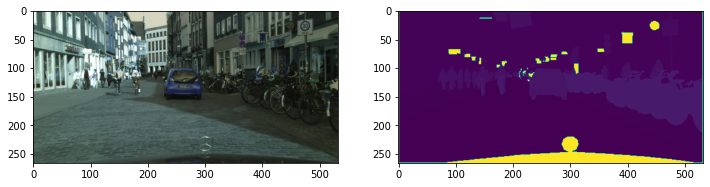

In [56]:
img = read_image(ds_val.imgs_files[120])
mask = read_image(ds_val.labels_files[120])
plot_two_imgs(img, mask[:,:,0])

In [59]:
x, y = ds_val[120]
x.shape


torch.Size([3, 256, 512])

In [60]:
x1 = x[None,]
x1.shape

torch.Size([1, 3, 256, 512])

In [61]:
y_hat = model(torch.FloatTensor(x1).to(device))
y_hat.shape

torch.Size([1, 20, 256, 512])

In [62]:
pred = torch.max(y_hat, 1)[1]
pred.shape

torch.Size([1, 256, 512])

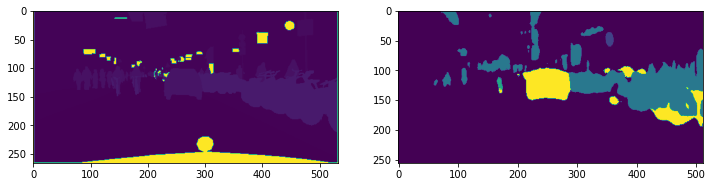

In [63]:
plot_two_imgs(mask[:,:,0], pred[0].cpu().numpy())


# Pretrained

In [64]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models


def createDeepLabv3(outputchannels=1):
    """DeepLabv3 class with custom head
    Args:
        outputchannels (int, optional): The number of output channels
        in your dataset masks. Defaults to 1.
    Returns:
        model: Returns the DeepLabv3 model with the ResNet101 backbone.
    """
    model = models.segmentation.deeplabv3_resnet101(pretrained=True,
                                                    progress=True)
    model.classifier = DeepLabHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model

In [96]:
model_1 = createDeepLabv3(outputchannels=20).to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [97]:
dl_train = DataLoader(ds_train, batch_size=2, shuffle=True, num_workers=2)
dl_val = DataLoader(ds_val, batch_size=2, shuffle=False, num_workers=2)

In [98]:
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=1e-4)


In [111]:
x, y = next(iter(dl_train))
x.shape, y.shape
x = x.to(device)
y = y.to(device)
#x = x.float()
y_hat = model_1(x)
y_hat.keys()

odict_keys(['out', 'aux'])

In [112]:
y_hat['aux'].shape

torch.Size([2, 21, 256, 512])

In [113]:
y_hat['out'].shape

torch.Size([2, 20, 256, 512])

In [114]:
y_hat = y_hat['out']
loss = F.cross_entropy(y_hat, y.long())

In [115]:
loss

tensor(2.8406, device='cuda:0', grad_fn=<NllLoss2DBackward0>)